# Mood Classification with 4 Classes and Temporal Models

This notebook implements classification algorithms to predict the mood of the next day for subjects in the dataset, using 4 mood classes and including a temporal algorithm (Hidden Markov Model).

## Contents
1. Imports and Setup
2. Data Loading and Preparation
3. Exploratory Data Analysis
4. Feature Engineering (4-Class Classification)
5. Model Training and Evaluation
6. Temporal Model (Hidden Markov Model)
7. Model Comparison and Results

In [57]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
from IPython.display import display

# For data preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# For model training and evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Classification algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Temporal algorithms
from hmmlearn import hmm
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier

# For sequence preparation
from collections import defaultdict

# Import our custom cleaning module
import cleaning

# Set random seed for reproducibility
np.random.seed(42)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Create plots directory if it doesn't exist
if not os.path.exists("./plots"):
    os.makedirs("./plots")

In [58]:
def load_and_prepare_data(file_path="./Data/dataset_mood_smartphone.csv"):
    """
    Load and prepare the data for analysis and modeling.
    """
    print("Loading and preparing data...")
    
    # Load the data using our existing cleaning module
    raw_data, users = cleaning.loadData(file_path)
    
    # Resample to daily data
    daily_data = cleaning.resample_daily(raw_data, users)
    
    # Prune to keep only the longest continuous period with mood data
    pruned_daily = cleaning.pruneDays(daily_data, users, method="longest", baseFrame=raw_data)
    
    print(f"Data loaded successfully. Found {len(users)} users.")
    
    return pruned_daily, users

# Load the data
data, users = load_and_prepare_data()

Loading and preparing data...
Data loaded successfully. Found 27 users.



--- Exploratory Data Analysis ---

Summary Statistics:


variable,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,screen,sms,call,activity,circumplex.arousal,circumplex.valence,mood
count,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1091.000000,1093.000000
mean,1266.444729,2562.786359,865.757340,18.526379,84.063745,73.798800,160.903924,1035.656766,112.081573,31.427018,39.093540,3.614087,5676.249532,0.855444,2.253431,0.108841,-0.121051,0.692751,6.973643
std,3905.649916,2530.452205,1771.776292,77.807550,508.033619,1021.391544,385.151874,1793.963594,474.722960,146.314704,155.102177,18.141762,4744.761639,1.853410,3.232844,0.095020,0.662378,0.434853,0.750809
min,-80367.930000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,-1.250000,3.000000
25%,162.032000,649.433000,0.000000,0.000000,0.000000,0.000000,38.161000,17.041000,0.000000,0.000000,0.000000,0.000000,1930.908000,0.000000,0.000000,0.041876,-0.600000,0.400000,6.600000
50%,635.303000,1882.340000,217.571000,0.000000,0.000000,0.000000,61.305000,396.672000,0.000000,0.000000,0.000000,0.000000,4765.971998,0.000000,1.000000,0.090177,0.000000,0.800000,7.000000
75%,1442.645000,3706.306000,1091.925000,0.000000,0.000000,0.000000,125.669000,1495.451000,64.902000,0.000000,10.033000,0.000000,8186.036001,1.000000,3.000000,0.143134,0.333333,1.000000,7.500000
max,40323.877000,20718.749000,35937.645000,1321.104000,12996.495000,33283.021000,4335.307000,30073.421000,10548.116000,2821.547000,2257.626000,366.937000,36204.105001,15.000000,25.000000,0.543843,2.000000,2.000000,9.333333



Missing Values:


variable
appCat.builtin          0
appCat.communication    0
appCat.entertainment    0
appCat.finance          0
appCat.game             0
appCat.office           0
appCat.other            0
appCat.social           0
appCat.travel           0
appCat.unknown          0
appCat.utilities        0
appCat.weather          0
screen                  0
sms                     0
call                    0
activity                0
circumplex.arousal      0
circumplex.valence      2
mood                    0
dtype: int64

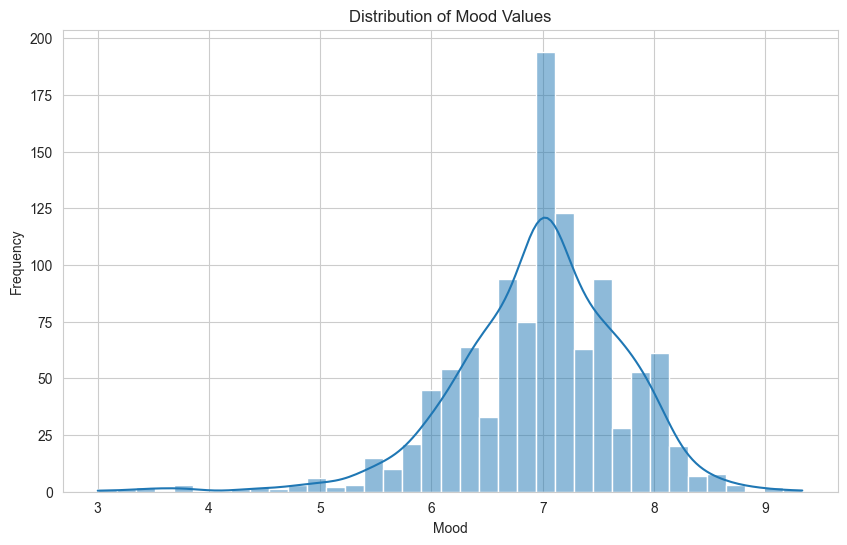

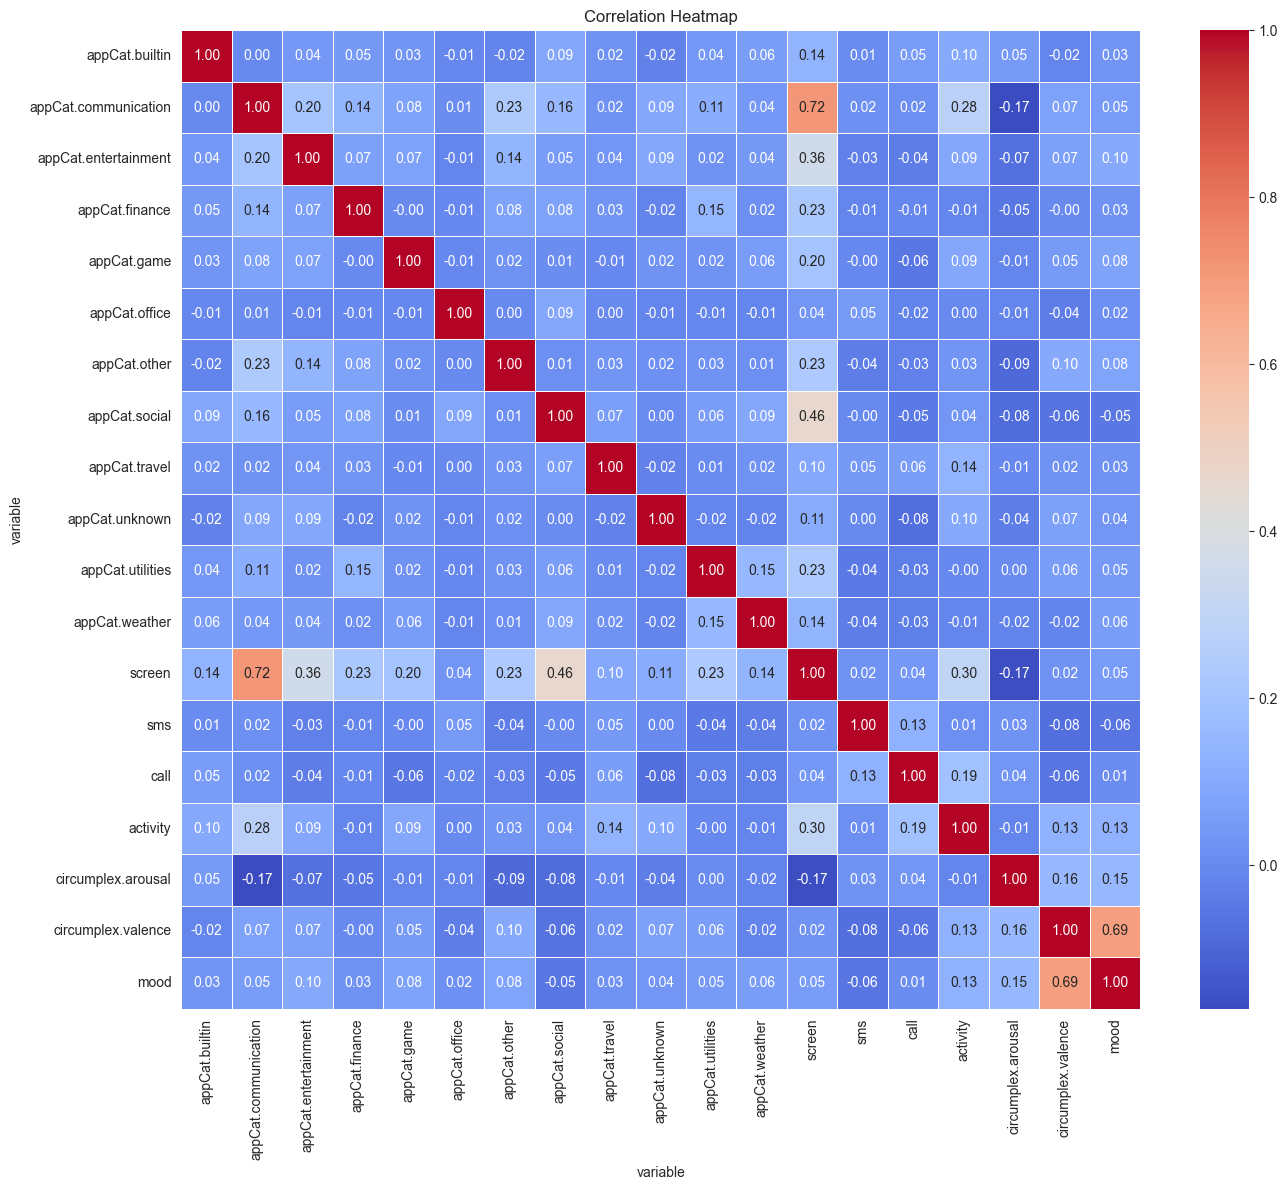

EDA completed.


In [59]:
def perform_eda(data):
    """
    Perform Exploratory Data Analysis on the dataset.
    """
    print("\n--- Exploratory Data Analysis ---")
    
    # 1. Summary statistics
    print("\nSummary Statistics:")
    summary_stats = data.describe()
    display(summary_stats)
    
    # 2. Check for missing values
    print("\nMissing Values:")
    missing_values = data.isna().sum()
    display(missing_values)
    
    # 3. Distribution of mood values
    plt.figure(figsize=(10, 6))
    sns.histplot(data["mood"].dropna(), kde=True)
    plt.title("Distribution of Mood Values")
    plt.xlabel("Mood")
    plt.ylabel("Frequency")
    plt.savefig("./plots/mood_distribution.png")
    plt.show()
    
    # 4. Correlation heatmap of numeric columns
    plt.figure(figsize=(14, 12))
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    corr_matrix = data[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.savefig("./plots/correlation_heatmap.png")
    plt.show()
    
    print("EDA completed.")
    
    return summary_stats, missing_values

# Perform EDA
summary_stats, missing_values = perform_eda(data)


--- Preparing Features and Target ---
Features and target prepared. X shape: (1034, 18), y shape: (1034,)
Class distribution: [225 218 274 317]


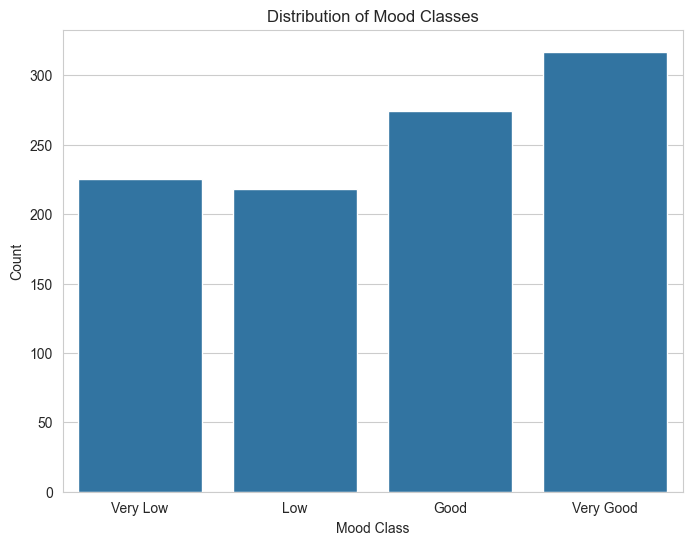

In [ ]:
def prepare_features_and_target(data, users):
    # Create a copy of the data
    processed_data = data.copy()
    
    # Fill missing values with median for each user
    for user in users:
        for col in processed_data.columns:
            if processed_data.loc[user][col].isna().any():
                user_median = processed_data.loc[user][col].median()
                if pd.isna(user_median):
                    user_median = 0
                processed_data.loc[user, col] = processed_data.loc[user][col].fillna(user_median)
    
    # Create features and target dataframes
    X_data = []
    y_data = []
    user_ids = []  # Store user IDs for temporal models
    timestamps = []  # Store timestamps for temporal models
    
    for user in users:
        user_data = processed_data.loc[user]
        
        # Skip users with less than 2 days of data
        if len(user_data) < 2:
            continue
            
        # For each day, use current day's data to predict next day's mood
        for i in range(len(user_data) - 1):
            # Current day's features
            features = user_data.iloc[i].drop('mood').values
            
            # Next day's mood (target)
            next_day_mood = user_data.iloc[i+1]['mood']
            
            # Convert to 4 classes based on quartiles
            # Class 0: Very low mood (0-25th percentile)
            # Class 1: Low mood (25-50th percentile)
            # Class 2: Good mood (50-75th percentile)
            # Class 3: Very good mood (75-100th percentile)
            user_mood_quartiles = user_data['mood'].quantile([0.25, 0.5, 0.75]).values
            
            if next_day_mood < user_mood_quartiles[0]:
                mood_class = 0  # Very low mood
            elif next_day_mood < user_mood_quartiles[1]:
                mood_class = 1  # Low mood
            elif next_day_mood < user_mood_quartiles[2]:
                mood_class = 2  # Good mood
            else:
                mood_class = 3  # Very good mood
            
            # Only add if there are no NaN values in the features
            if not np.isnan(features).any():
                X_data.append(features)
                y_data.append(mood_class)
                user_ids.append(user)
                timestamps.append(user_data.index[i+1])  # Next day's timestamp
    
    # Convert to numpy arrays
    X = np.array(X_data)
    y = np.array(y_data)
    user_ids = np.array(user_ids)
    timestamps = np.array(timestamps)
    
    # Get feature names (excluding 'mood')
    feature_names = [col for col in processed_data.columns if col != 'mood']
    
    # Visualize class distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x=y)
    plt.title('Distribution of Mood Classes')
    plt.xlabel('Mood Class')
    plt.xticks([0, 1, 2, 3], ['Very Low', 'Low', 'Good', 'Very Good'])
    plt.ylabel('Count')
    plt.savefig("./plots/class_distribution.png")
    plt.show()
    
    return X, y, feature_names, user_ids, timestamps

# Prepare features and target
X, y, feature_names, user_ids, timestamps = prepare_features_and_target(data, users)

In [ ]:
def train_and_evaluate_models(X, y, feature_names, user_ids=None, timestamps=None):
    # Check for any remaining NaN values
    if np.isnan(X).any():
        print("WARNING: NaN values detected in features. Removing rows with NaN values.")
        # Find rows without NaN values
        mask = ~np.isnan(X).any(axis=1)
        X = X[mask]
        y = y[mask]
        if user_ids is not None:
            user_ids = user_ids[mask]
        if timestamps is not None:
            timestamps = timestamps[mask]
        print(f"After removing NaN values: X shape: {X.shape}, y shape: {y.shape}")
    
    # Split data into training and testing sets (80% train, 20% test)
    if user_ids is not None and timestamps is not None:
        # Use time-based split for temporal data
        # Sort by timestamp
        sorted_indices = np.argsort(timestamps)
        X = X[sorted_indices]
        y = y[sorted_indices]
        user_ids = user_ids[sorted_indices]
        timestamps = timestamps[sorted_indices]
        
        # Use the last 20% as test set
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        user_ids_train, user_ids_test = user_ids[:split_idx], user_ids[split_idx:]
        timestamps_train, timestamps_test = timestamps[:split_idx], timestamps[split_idx:]
    else:
        # Regular stratified split for non-temporal models
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models to evaluate
    models = {
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'KNN': KNeighborsClassifier(),
        'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr', max_iter=1000)
    }
    
    # Dictionary to store results
    results = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        try:
            # Train the model
            model.fit(X_train_scaled, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test_scaled)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            # Use macro averaging for multi-class classification
            precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
            recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
            
            # Print results
            print(f"{name} Results:")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            
            # Print classification report
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred, zero_division=0))
            
            # Print confusion matrix
            print("\nConfusion Matrix:")
            cm = confusion_matrix(y_test, y_pred)
            print(cm)
            
            # Plot confusion matrix
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=['Very Low', 'Low', 'Good', 'Very Good'],
                        yticklabels=['Very Low', 'Low', 'Good', 'Very Good'])
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title(f'Confusion Matrix - {name}')
            plt.tight_layout()
            plt.savefig(f"./plots/confusion_matrix_{name.replace(' ', '_').lower()}.png")
            plt.show()
            
            # Store results
            results[name] = {
                'model': model,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'confusion_matrix': cm,
                'y_pred': y_pred
            }
            
            # Feature importance for tree-based models
            if name in ['Decision Tree', 'Random Forest']:
                importances = model.feature_importances_
                indices = np.argsort(importances)[::-1]
                
                # Plot feature importance
                plt.figure(figsize=(12, 8))
                plt.title(f'Feature Importance - {name}')
                plt.bar(range(min(10, X.shape[1])), importances[indices[:10]], align='center')
                plt.xticks(range(min(10, X.shape[1])), [feature_names[i] for i in indices[:10]], rotation=90)
                plt.tight_layout()
                plt.savefig(f"./plots/feature_importance_{name.replace(' ', '_').lower()}.png")
                plt.show()
                
                # Print top 10 features
                print("\nTop 10 Features:")
                for i in range(min(10, X.shape[1])):
                    print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
        
        except Exception as e:
            print(f"Error training {name}: {str(e)}")
            print(f"Skipping {name} model.")
    
    return results, X_train_scaled, y_train, X_test_scaled, y_test, user_ids_train, user_ids_test


--- Training and Evaluating Models ---

Training Decision Tree...
Decision Tree Results:
Accuracy: 0.2415
Precision: 0.2361
Recall: 0.2393
F1 Score: 0.2361

Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.34      0.30        44
           1       0.13      0.14      0.14        42
           2       0.22      0.20      0.21        56
           3       0.32      0.28      0.30        65

    accuracy                           0.24       207
   macro avg       0.24      0.24      0.24       207
weighted avg       0.24      0.24      0.24       207


Confusion Matrix:
[[15  9 11  9]
 [13  6 11 12]
 [13 15 11 17]
 [14 16 17 18]]


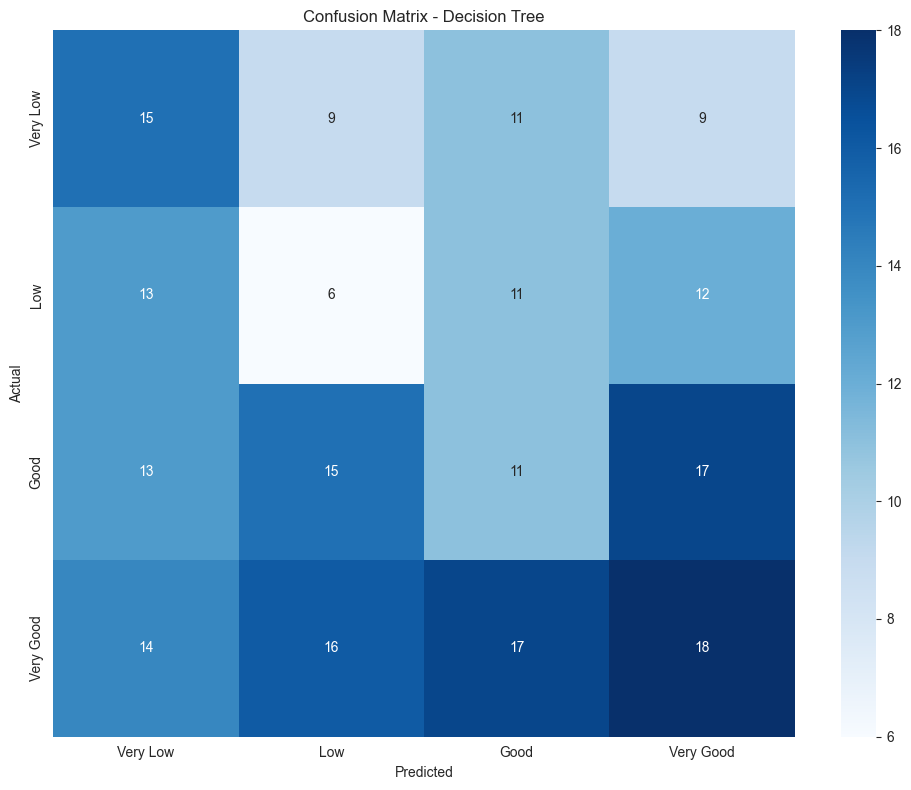

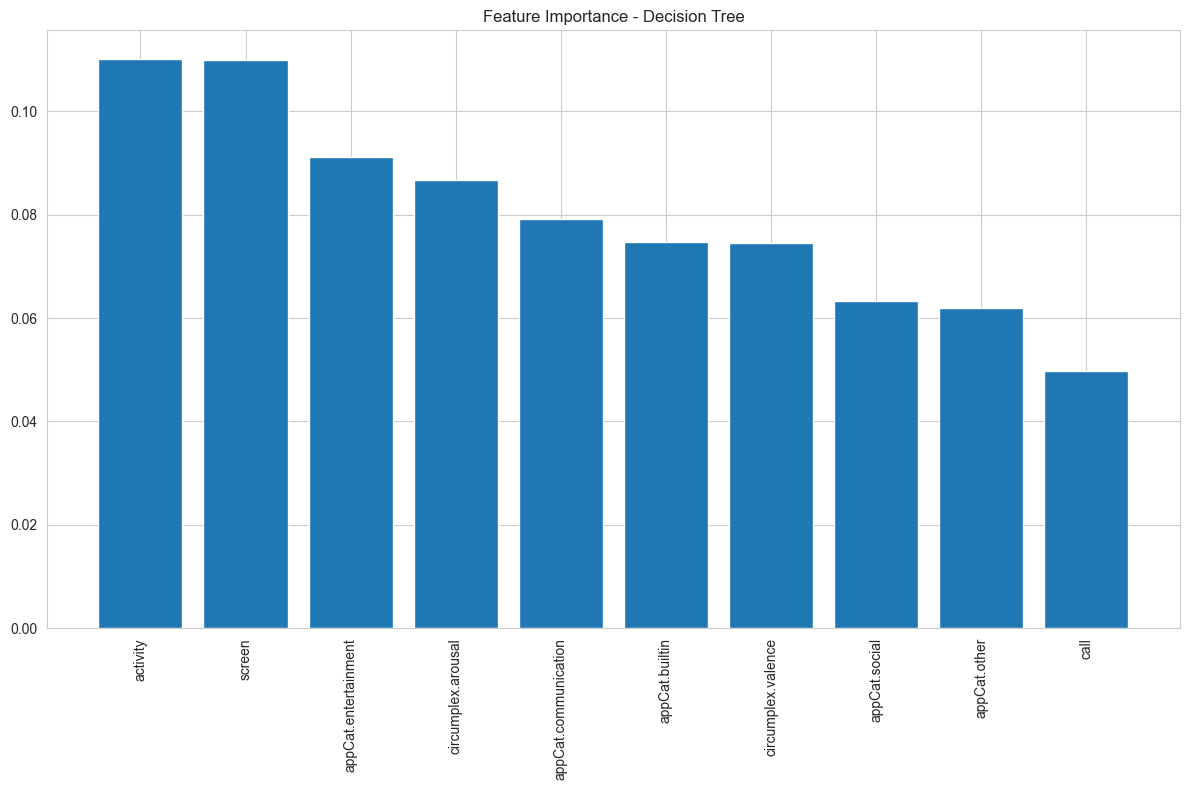


Top 10 Features:
activity: 0.1101
screen: 0.1099
appCat.entertainment: 0.0911
circumplex.arousal: 0.0867
appCat.communication: 0.0792
appCat.builtin: 0.0747
circumplex.valence: 0.0745
appCat.social: 0.0633
appCat.other: 0.0620
call: 0.0498

Training Random Forest...
Random Forest Results:
Accuracy: 0.2899
Precision: 0.2631
Recall: 0.2708
F1 Score: 0.2633

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.32      0.33        44
           1       0.12      0.07      0.09        42
           2       0.22      0.23      0.23        56
           3       0.36      0.46      0.40        65

    accuracy                           0.29       207
   macro avg       0.26      0.27      0.26       207
weighted avg       0.27      0.29      0.28       207


Confusion Matrix:
[[14  5 12 13]
 [ 6  3 12 21]
 [13 10 13 20]
 [ 7  6 22 30]]


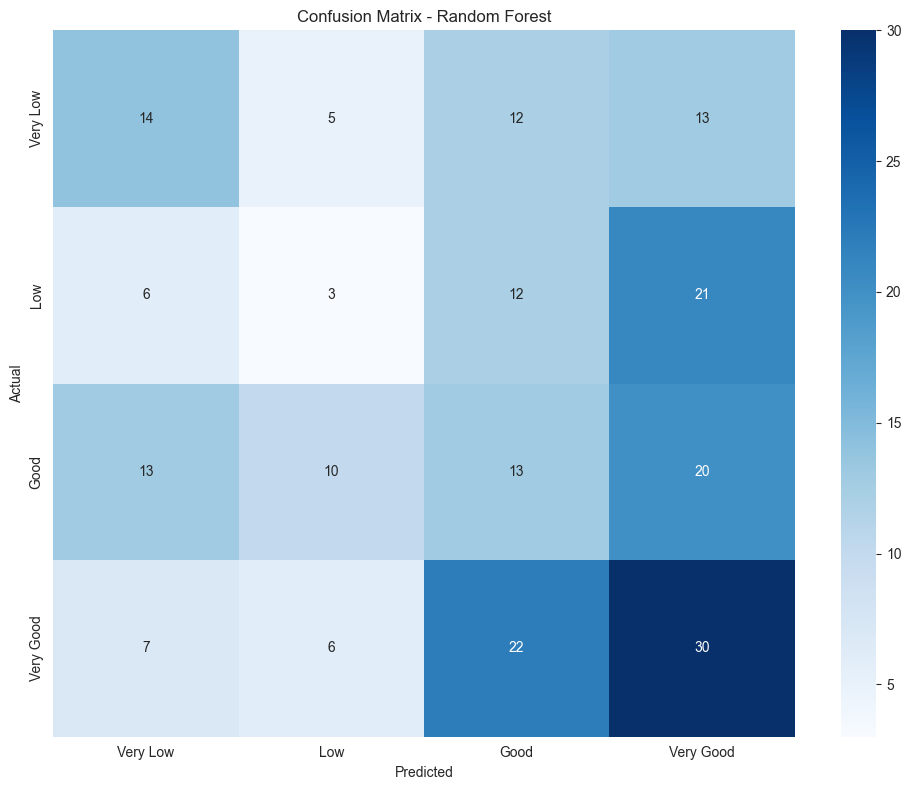

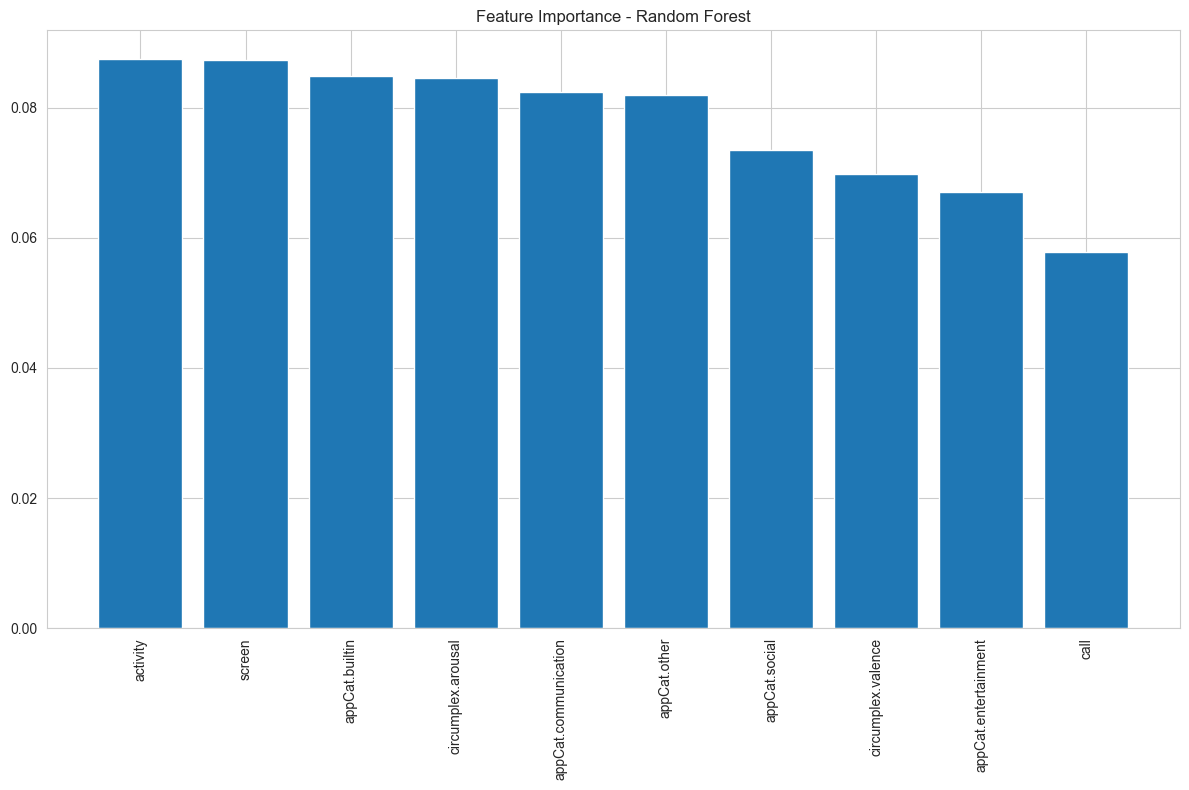


Top 10 Features:
activity: 0.0875
screen: 0.0873
appCat.builtin: 0.0849
circumplex.arousal: 0.0846
appCat.communication: 0.0825
appCat.other: 0.0819
appCat.social: 0.0734
circumplex.valence: 0.0698
appCat.entertainment: 0.0671
call: 0.0578

Training SVM...
SVM Results:
Accuracy: 0.2802
Precision: 0.2014
Recall: 0.2464
F1 Score: 0.2033

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.25      0.29        44
           1       0.00      0.00      0.00        42
           2       0.17      0.09      0.12        56
           3       0.30      0.65      0.41        65

    accuracy                           0.28       207
   macro avg       0.20      0.25      0.20       207
weighted avg       0.21      0.28      0.22       207


Confusion Matrix:
[[11  2  6 25]
 [ 4  0  4 34]
 [11  1  5 39]
 [ 7  2 14 42]]


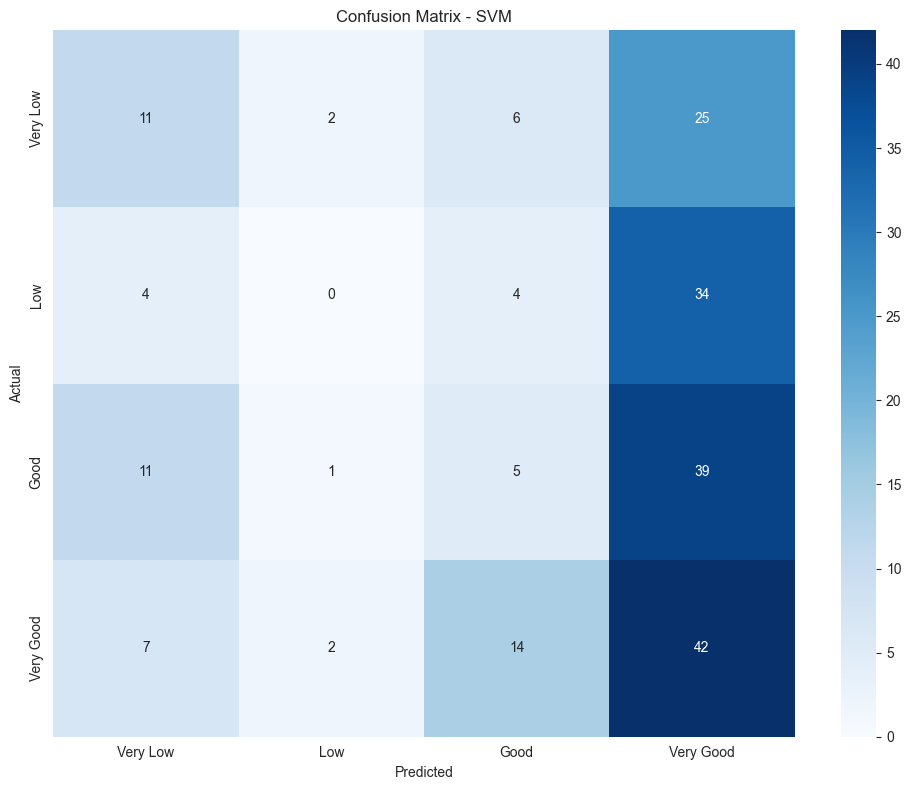


Training KNN...
KNN Results:
Accuracy: 0.2271
Precision: 0.2261
Recall: 0.2286
F1 Score: 0.2253

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.32      0.28        44
           1       0.14      0.17      0.15        42
           2       0.26      0.21      0.23        56
           3       0.25      0.22      0.23        65

    accuracy                           0.23       207
   macro avg       0.23      0.23      0.23       207
weighted avg       0.23      0.23      0.23       207


Confusion Matrix:
[[14 11  8 11]
 [11  7  9 15]
 [18 11 12 15]
 [12 21 18 14]]


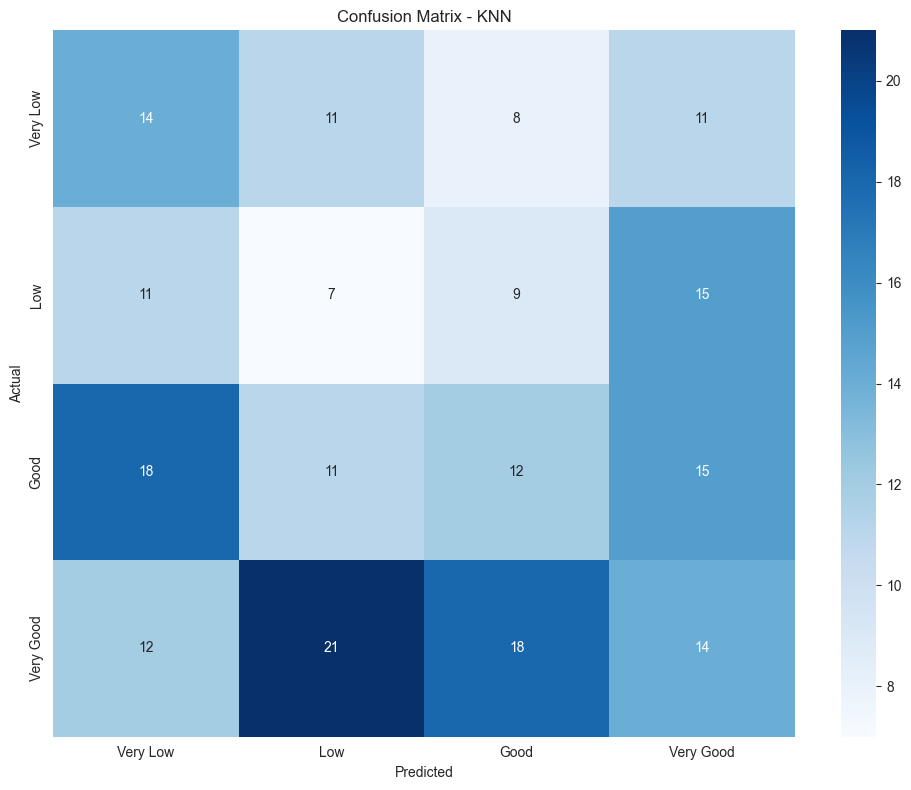


Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.3430
Precision: 0.3306
Recall: 0.3162
F1 Score: 0.2751

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.43      0.37        44
           1       0.33      0.02      0.04        42
           2       0.30      0.18      0.22        56
           3       0.37      0.63      0.47        65

    accuracy                           0.34       207
   macro avg       0.33      0.32      0.28       207
weighted avg       0.33      0.34      0.29       207


Confusion Matrix:
[[19  0  7 18]
 [11  1  5 25]
 [17  2 10 27]
 [13  0 11 41]]


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


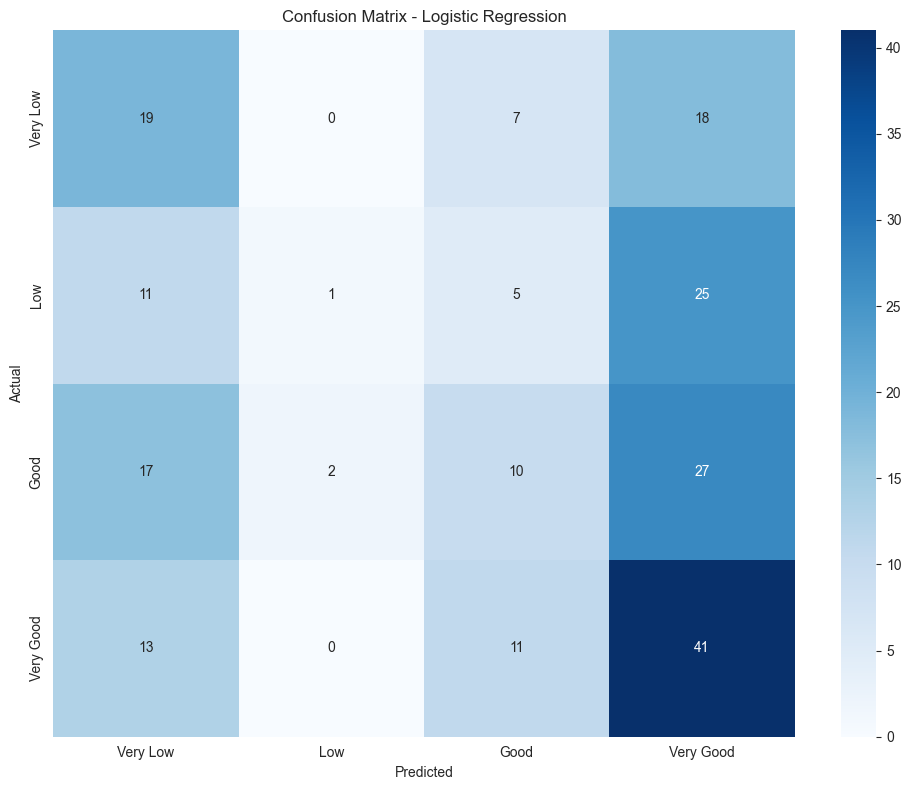

In [62]:
# Train and evaluate standard classification models
results, X_train_scaled, y_train, X_test_scaled, y_test, user_ids_train, user_ids_test = train_and_evaluate_models(
    X, y, feature_names, user_ids, timestamps
)

In [63]:
def train_hmm(X_train, y_train, X_test, y_test, user_ids_train, user_ids_test):
    """
    Train a Hidden Markov Model for temporal mood prediction.
    """
    print("\nTraining Hidden Markov Model (HMM)...")
    
    # Group data by user to create sequences
    user_sequences = defaultdict(list)
    user_labels = defaultdict(list)
    
    # Create sequences for each user
    for i in range(len(X_train)):
        user = user_ids_train[i]
        user_sequences[user].append(X_train[i])
        user_labels[user].append(y_train[i])
    
    # Initialize HMM with 4 hidden states (one for each mood class)
    model = hmm.GaussianHMM(n_components=4, covariance_type="diag", n_iter=100, random_state=42)
    
    # Prepare data for HMM training
    X_hmm = []
    lengths = []
    
    for user, sequence in user_sequences.items():
        if len(sequence) > 1:  # Need at least 2 observations for HMM
            X_hmm.extend(sequence)
            lengths.append(len(sequence))
    
    # Convert to numpy array
    X_hmm = np.vstack(X_hmm)
    
    # Train HMM
    model.fit(X_hmm, lengths=lengths)
    
    # Predict on test set
    # Group test data by user
    test_user_sequences = defaultdict(list)
    test_user_indices = defaultdict(list)
    
    for i in range(len(X_test)):
        user = user_ids_test[i]
        test_user_sequences[user].append(X_test[i])
        test_user_indices[user].append(i)
    
    # Make predictions
    y_pred = np.zeros(len(y_test))
    
    for user, sequence in test_user_sequences.items():
        if len(sequence) > 0:
            # Convert to numpy array
            seq_array = np.vstack(sequence)
            
            # Predict hidden states
            hidden_states = model.predict(seq_array)
            
            # Map hidden states to mood classes (using majority vote from training)
            state_to_mood = {}
            for state in range(4):
                # Find the most common mood class for each hidden state in training
                state_indices = (model.predict(X_hmm) == state)
                if np.any(state_indices):
                    # Get corresponding training labels
                    state_labels = []
                    idx = 0
                    for length in lengths:
                        for j in range(length):
                            if state_indices[idx + j]:
                                user_id = list(user_sequences.keys())[sum(i < idx + j for i in np.cumsum(lengths)) - 1]
                                label_idx = j
                                if label_idx < len(user_labels[user_id]):
                                    state_labels.append(user_labels[user_id][label_idx])
                        idx += length
                    
                    if state_labels:
                        # Assign the most common mood class to this state
                        state_to_mood[state] = max(set(state_labels), key=state_labels.count)
                    else:
                        # If no examples, assign a default class
                        state_to_mood[state] = 0
                else:
                    # If state never occurs in training, assign a default class
                    state_to_mood[state] = 0
            
            # Map hidden states to mood classes
            for i, state in enumerate(hidden_states):
                idx = test_user_indices[user][i]
                y_pred[idx] = state_to_mood.get(state, 0)  # Default to class 0 if state not in mapping
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # Print results
    print("HMM Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Print confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Very Low', 'Low', 'Good', 'Very Good'],
                yticklabels=['Very Low', 'Low', 'Good', 'Very Good'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - HMM')
    plt.tight_layout()
    plt.savefig("./plots/confusion_matrix_hmm.png")
    plt.show()
    
    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'y_pred': y_pred
    }


Training Hidden Markov Model (HMM)...


Model is not converging.  Current: -6234.311963289598 is not greater than -6234.012605898871. Delta is -0.299357390726982


HMM Results:
Accuracy: 0.3140
Precision: 0.0785
Recall: 0.2500
F1 Score: 0.1195

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.00      0.00      0.00        42
           2       0.00      0.00      0.00        56
           3       0.31      1.00      0.48        65

    accuracy                           0.31       207
   macro avg       0.08      0.25      0.12       207
weighted avg       0.10      0.31      0.15       207


Confusion Matrix:
[[ 0  0  0 44]
 [ 0  0  0 42]
 [ 0  0  0 56]
 [ 0  0  0 65]]


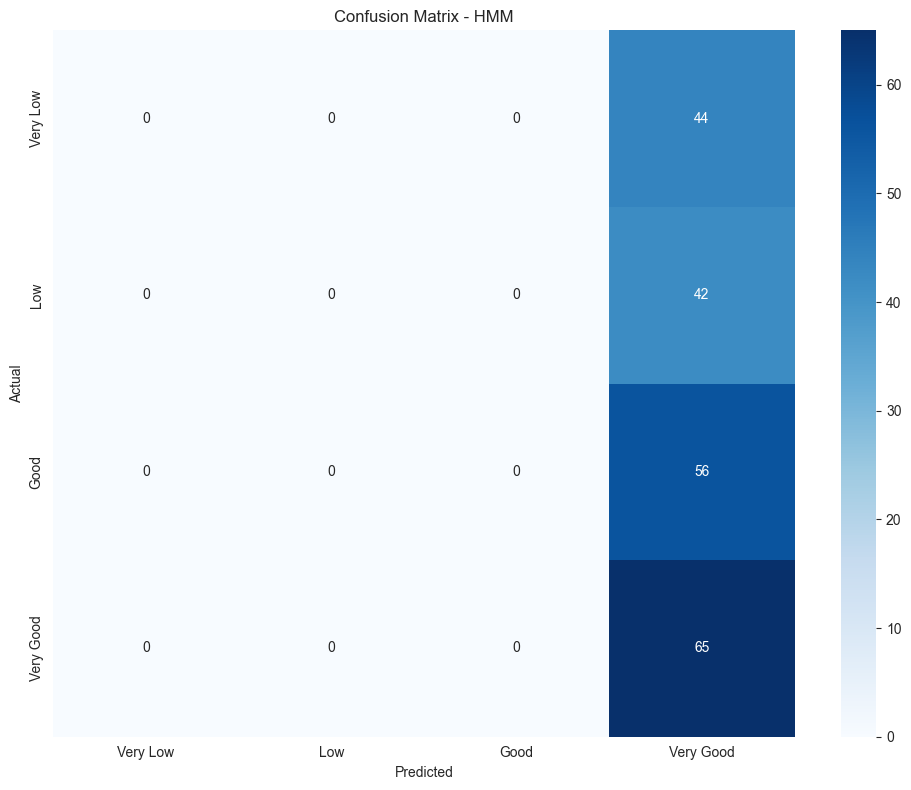

In [64]:
# Train Hidden Markov Model
try:
    hmm_results = train_hmm(X_train_scaled, y_train, X_test_scaled, y_test, user_ids_train, user_ids_test)
    results['HMM'] = hmm_results
except Exception as e:
    print(f"Error training HMM: {str(e)}")
    print("Skipping HMM model.")


--- Model Comparison ---

Model Comparison:


,Model,accuracy,precision,recall,f1
0,Decision Tree,0.241546,0.236148,0.239279,0.236115
1,Random Forest,0.289855,0.263120,0.270823,0.263253
2,SVM,0.280193,0.201437,0.246360,0.203279
3,KNN,0.227053,0.226103,0.228630,0.225336
4,Logistic Regression,0.342995,0.330600,0.316242,0.275114
5,HMM,0.314010,0.078502,0.250000,0.119485


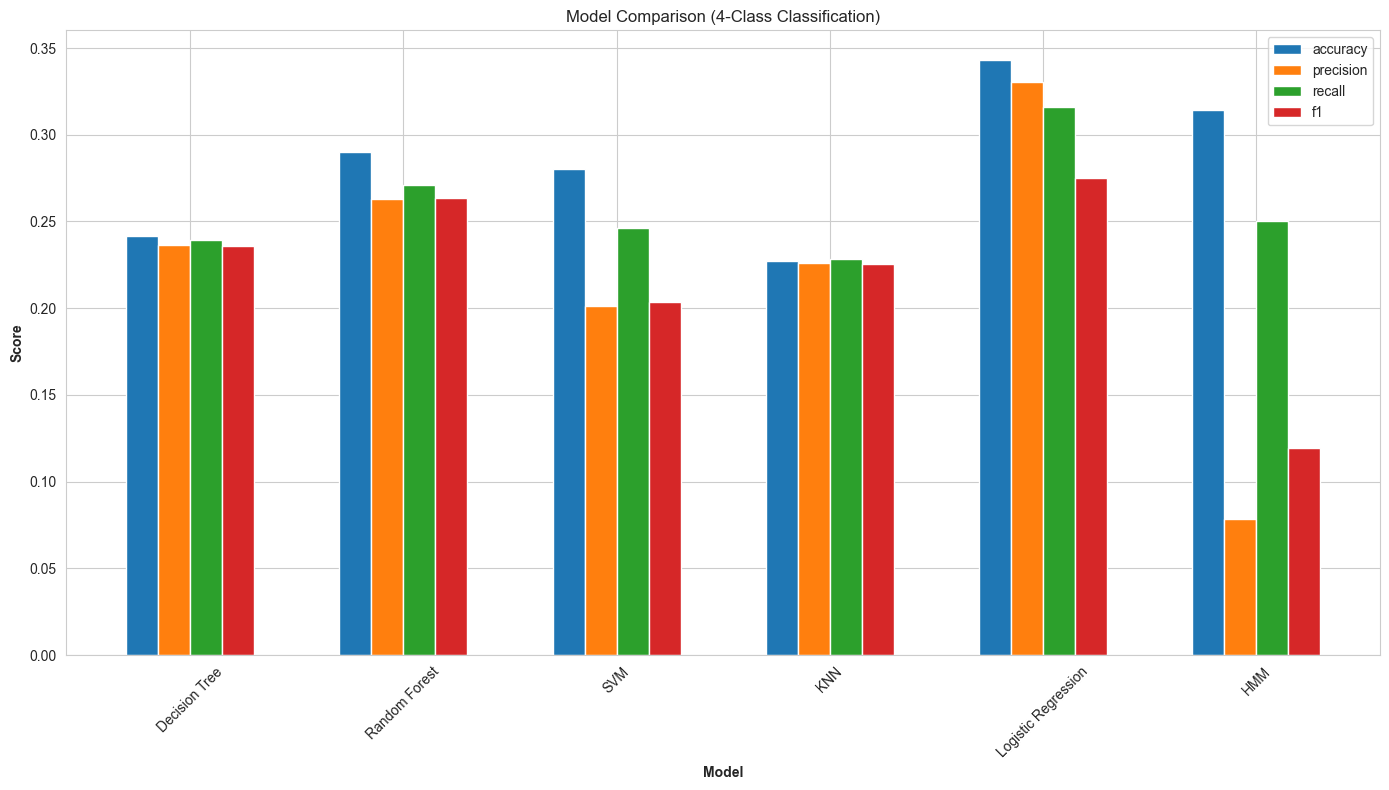


Best Model: Logistic Regression
F1 Score: 0.2751

Detailed Class Performance:

Decision Tree - Confusion Matrix:


,Pred: Very Low,Pred: Low,Pred: Good,Pred: Very Good
True: Very Low,15,9,11,9
True: Low,13,6,11,12
True: Good,13,15,11,17
True: Very Good,14,16,17,18



Random Forest - Confusion Matrix:


,Pred: Very Low,Pred: Low,Pred: Good,Pred: Very Good
True: Very Low,14,5,12,13
True: Low,6,3,12,21
True: Good,13,10,13,20
True: Very Good,7,6,22,30



SVM - Confusion Matrix:


,Pred: Very Low,Pred: Low,Pred: Good,Pred: Very Good
True: Very Low,11,2,6,25
True: Low,4,0,4,34
True: Good,11,1,5,39
True: Very Good,7,2,14,42



KNN - Confusion Matrix:


,Pred: Very Low,Pred: Low,Pred: Good,Pred: Very Good
True: Very Low,14,11,8,11
True: Low,11,7,9,15
True: Good,18,11,12,15
True: Very Good,12,21,18,14



Logistic Regression - Confusion Matrix:


,Pred: Very Low,Pred: Low,Pred: Good,Pred: Very Good
True: Very Low,19,0,7,18
True: Low,11,1,5,25
True: Good,17,2,10,27
True: Very Good,13,0,11,41



HMM - Confusion Matrix:


,Pred: Very Low,Pred: Low,Pred: Good,Pred: Very Good
True: Very Low,0,0,0,44
True: Low,0,0,0,42
True: Good,0,0,0,56
True: Very Good,0,0,0,65


In [ ]:
def compare_models(results):
    # Create a DataFrame with model results
    model_names = list(results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    comparison_data = []
    for name in model_names:
        row = [name]
        for metric in metrics:
            row.append(results[name][metric])
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data, columns=['Model'] + metrics)
    
    # Print comparison table
    print("\nModel Comparison:")
    display(comparison_df)
    
    # Plot comparison
    plt.figure(figsize=(14, 8))
    
    # Set width of bars
    barWidth = 0.15
    
    # Set positions of the bars on X axis
    r = np.arange(len(model_names))
    
    # Create bars
    for i, metric in enumerate(metrics):
        plt.bar(r + i * barWidth, comparison_df[metric], width=barWidth, label=metric)
    
    # Add labels and title
    plt.xlabel('Model', fontweight='bold')
    plt.ylabel('Score', fontweight='bold')
    plt.title('Model Comparison (4-Class Classification)')
    plt.xticks(r + barWidth * (len(metrics) - 1) / 2, model_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig("./plots/model_comparison_4class.png")
    plt.show()
    
    # Find the best model based on F1 score
    best_model_idx = comparison_df['f1'].idxmax()
    best_model_name = comparison_df.loc[best_model_idx, 'Model']
    best_model = results[best_model_name]['model']
    
    print(f"\nBest Model: {best_model_name}")
    print(f"F1 Score: {results[best_model_name]['f1']:.4f}")
    
    # Create a more detailed comparison focusing on per-class performance
    print("\nDetailed Class Performance:")
    for name in model_names:
        print(f"\n{name} - Confusion Matrix:")
        display(pd.DataFrame(
            results[name]['confusion_matrix'],
            columns=['Pred: Very Low', 'Pred: Low', 'Pred: Good', 'Pred: Very Good'],
            index=['True: Very Low', 'True: Low', 'True: Good', 'True: Very Good']
        ))
    
    return best_model_name, best_model

# Compare models and find the best one
best_model_name, best_model = compare_models(results)

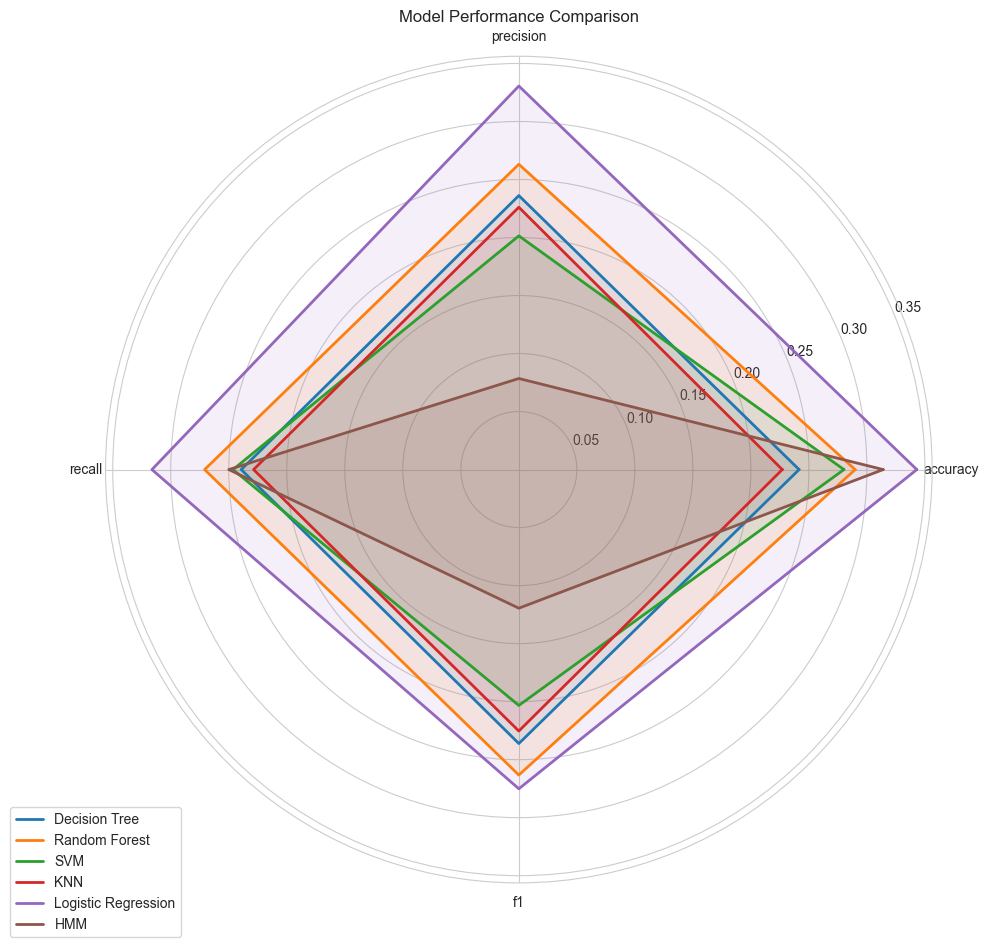

<Figure size 1200x800 with 0 Axes>

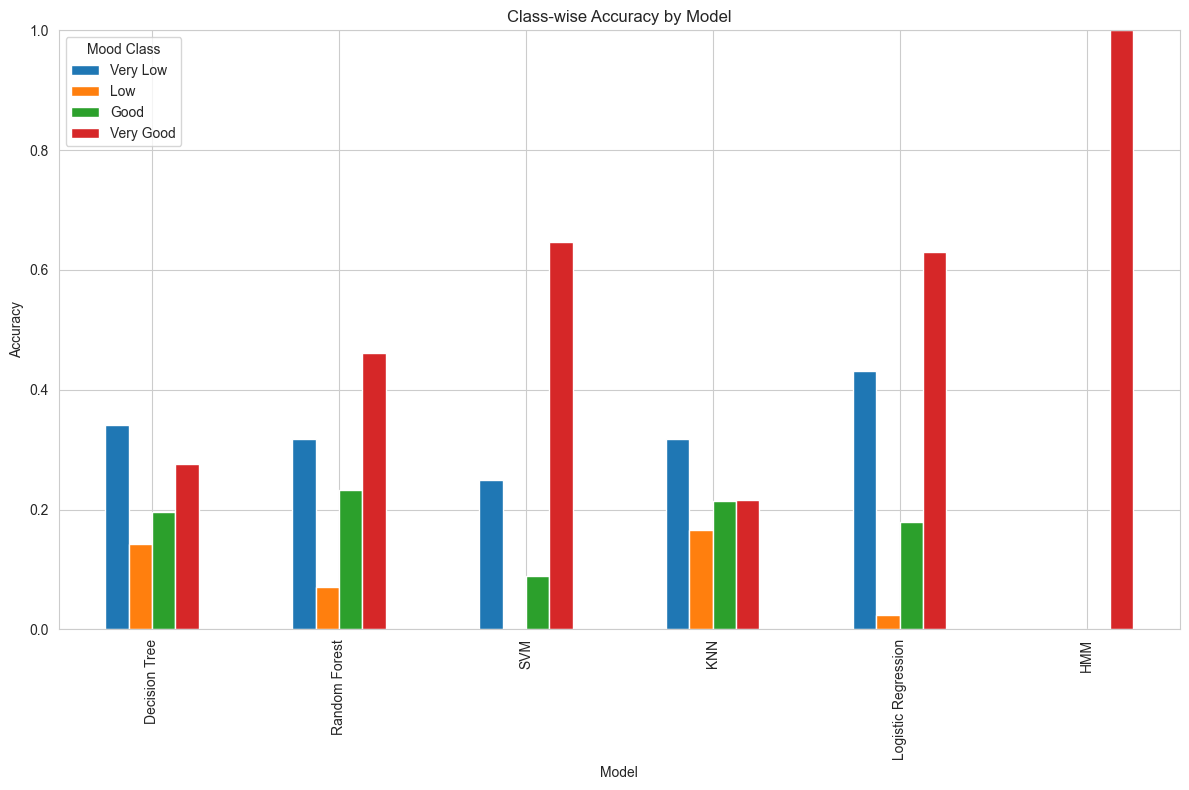

,Very Low,Low,Good,Very Good
Decision Tree,0.340909,0.142857,0.196429,0.276923
Random Forest,0.318182,0.071429,0.232143,0.461538
SVM,0.25,0.0,0.089286,0.646154
KNN,0.318182,0.166667,0.214286,0.215385
Logistic Regression,0.431818,0.02381,0.178571,0.630769
HMM,0.0,0.0,0.0,1.0


In [66]:
# Create a radar chart to visualize model performance across metrics
def radar_chart(results):
    """
    Create a radar chart to visualize model performance across metrics.
    """
    # Extract metrics
    model_names = list(results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    # Create a DataFrame for the radar chart
    radar_data = []
    for name in model_names:
        row = [name]
        for metric in metrics:
            row.append(results[name][metric])
        radar_data.append(row)
    
    radar_df = pd.DataFrame(radar_data, columns=['Model'] + metrics)
    radar_df = radar_df.set_index('Model')
    
    # Create the radar chart
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    
    # Number of variables
    categories = metrics
    N = len(categories)
    
    # Create angles for each metric
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Plot each model
    for i, model in enumerate(radar_df.index):
        values = radar_df.loc[model].values.flatten().tolist()
        values += values[:1]  # Close the loop
        
        # Plot values
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.1)
    
    # Set category labels
    plt.xticks(angles[:-1], categories)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.title('Model Performance Comparison')
    plt.tight_layout()
    plt.savefig("./plots/radar_chart_4class.png")
    plt.show()

# Create radar chart
radar_chart(results)

# Visualize predictions for each class
def visualize_class_predictions(results, y_test):
    """
    Visualize how each model performs for each mood class.
    """
    # Create a DataFrame to store class-wise accuracy
    class_accuracy = pd.DataFrame(index=results.keys(), columns=['Very Low', 'Low', 'Good', 'Very Good'])
    
    for model_name, model_results in results.items():
        y_pred = model_results['y_pred']
        
        # Calculate accuracy for each class
        for class_idx in range(4):
            # Get indices where true label is this class
            class_indices = (y_test == class_idx)
            if np.any(class_indices):
                # Calculate accuracy for this class
                class_acc = accuracy_score(y_test[class_indices], y_pred[class_indices])
                class_accuracy.loc[model_name, ['Very Low', 'Low', 'Good', 'Very Good'][class_idx]] = class_acc
    
    # Plot class-wise accuracy
    plt.figure(figsize=(12, 8))
    class_accuracy.plot(kind='bar')
    plt.title('Class-wise Accuracy by Model')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend(title='Mood Class')
    plt.tight_layout()
    plt.savefig("./plots/class_accuracy_4class.png")
    plt.show()
    
    return class_accuracy

# Visualize class predictions
class_accuracy = visualize_class_predictions(results, y_test)
display(class_accuracy)


### Future Improvements (AI):

1. **Enhanced Temporal Models**: Implement more sophisticated temporal models like LSTM networks or Transformer-based models.

2. **Feature Engineering**: Create more temporal features such as trend indicators and cyclical patterns.

3. **Class Balancing**: Apply techniques to address class imbalance.

4. **Hyperparameter Tuning**: Conduct more extensive hyperparameter optimization.

5. **Ensemble Methods**: Combine multiple models to improve prediction accuracy.